In [1]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot
using StatsBase
using Distributions
using OneHotArrays
using Statistics
using InvertedIndices
using ROCAnalysis

In [2]:
function randomPopulateMat(mat,symmetric=true)
#     for ii = 1:round(Int, percPopulate*size(mat)[1] )
#         row_tmp = rand( 1:size(mat)[1] )
#         col_tmp = rand( 1:size(mat)[1] )
#         if( row_tmp == col_tmp )
#             col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
#         end
#         mat[row_tmp,col_tmp] = 1
#         if(symmetric == true)
#             mat[col_tmp,row_tmp] = 1
#         end
#     end
    return adjacency_matrix(erdos_renyi( size(mat)[1] , size(mat)[1] ))
end

randomPopulateMat (generic function with 2 methods)

In [3]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [4]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

In [5]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [6]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:5] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],mean(bb).memory)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end

In [7]:
benchmarkDicts["time"]

5-element Vector{Any}:
   5344.58
  38500.25
 107054.1
      1.5466303e6
      1.52554597e7

In [8]:
benchmarkDicts["memory"]

5-element Vector{Any}:
     3376
    22992
   211120
  2091568
 20901344

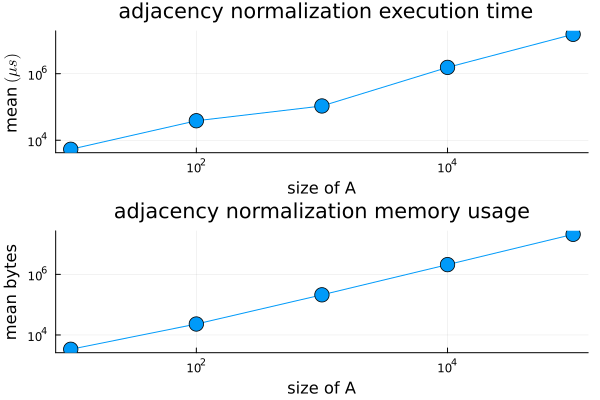

In [9]:
pTime = plot( NN , benchmarkDicts["time"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean " * L"(\mu s)")
title!(" adjacency normalization execution time")
pMemory = plot( NN , benchmarkDicts["memory"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean bytes")
title!("adjacency normalization memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [10]:
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
NN = [10^6]
percPopulate = 0.1
NNtmp = NN[1]
AA = spzeros(NNtmp,NNtmp);
AA = randomPopulateMat(AA);
AS = A2S(AA)
K = [0,1,2,3,4,6]
for ii in 1:length(K)
    kk = K[ii]
    bb = @benchmark A2k(AS,$kk)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    
end

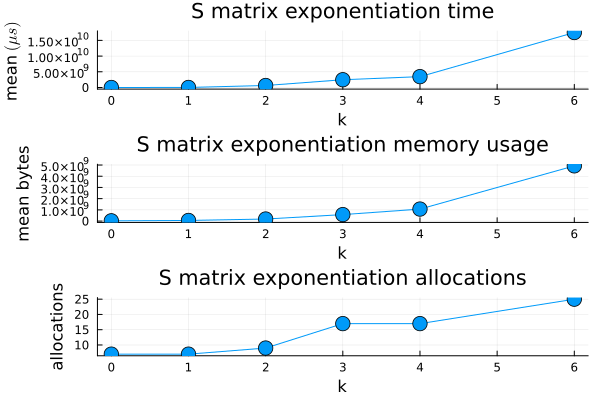

In [11]:
pTime = plot( K , benchmarkDicts_k["time"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean " * L"(\mu s)")
title!("S matrix exponentiation time")
pMemory = plot( K , benchmarkDicts_k["memory"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean bytes")
title!("S matrix exponentiation memory usage")
pAllocs = plot( K , benchmarkDicts_k["allocs"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("allocations")
title!("S matrix exponentiation allocations")
plot(pTime, pMemory, pAllocs, layout = Plots.grid(3,1) )

# generate the block diagonal data to experiment with

In [12]:
nn_max = 4
NN_set = [10^n for n in 2:nn_max];

In [13]:
ER_BA_SF_WS_Block_graphs = Dict()
ER_BA_SF_WS_Block_matrices = Dict()
for nn in 1:length(NN_set)    
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    ER_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) )
    BA_tmp = barabasi_albert( NN_tmp , 8 )
    SF_tmp = static_scale_free( NN_tmp , 8*(NN_tmp) , 4 )
    WS_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) ) #barabasi_albert( NN_tmp , 5 )
    blocks_tmp = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    
    ER_BA_SF_WS_Block_graphs[nn] = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    #now add some edges between the blocks that are the communities
    #>>>>    
    for bb in 1:Int(round(NN_tmp/10))
        for b1 in 0:3
            for b2 in 0:3
                if(b1 < b2)
                    range1 = randperm(NN_tmp)[1] + b1*NN_tmp
                    range2 = randperm(NN_tmp)[1] + b2*NN_tmp
                    add_edge!( ER_BA_SF_WS_Block_graphs[nn] , range1 , range2 )
                end
            end
        end
    end
    #<<<<
    density_nn = LightGraphs.density(ER_BA_SF_WS_Block_graphs[nn])
    println("nn=$(nn), density=$(density_nn)")
end
[ ER_BA_SF_WS_Block_matrices[ii] = Matrix(adjacency_matrix(ER_BA_SF_WS_Block_graphs[ii])) for ii in 1:length(NN_set) ]
ER_BA_SF_WS_Block_graphs

nn=1, density=0.1713131313131313
nn=2, density=0.018190190190190192
nn=3, density=0.001828902890289029


Dict{Any, Any} with 3 entries:
  2 => {1000, 9086} undirected simple Int64 graph
  3 => {10000, 91436} undirected simple Int64 graph
  1 => {100, 848} undirected simple Int64 graph

In [14]:
[ is_connected( ER_BA_SF_WS_Block_graphs[ii] ) for ii in 1:length(NN_set) ]

3-element Vector{Bool}:
 1
 1
 1

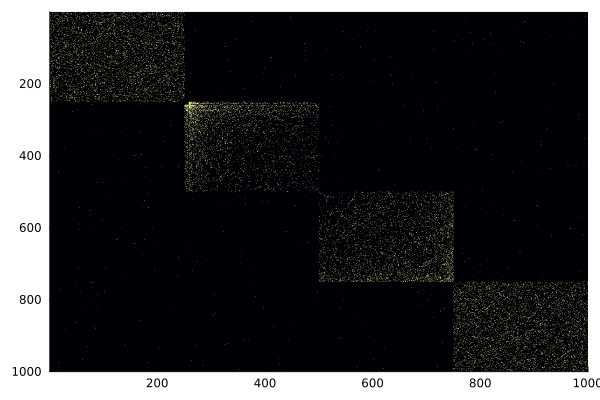

In [15]:
heatmap( ER_BA_SF_WS_Block_matrices[2] , yflip = true , legend = false )

# generate the X and Y variable data

In [16]:
d1 = Dirichlet( [10,10,10] )
c1 = Categorical( [0.5,0.25,0.25] )
d2 = Dirichlet( [20,10,10] )
c2 = Categorical( [0.35,0.35,0.3] )
d3 = Dirichlet( [20,10,20] )
c3 = Categorical( [0.25,0.25,0.5] )
# d1 = Dirichlet( [10,10] )
# c1 = Categorical( [0.5,0.5] )
# d2 = Dirichlet( [20,10] )
# c2 = Categorical( [0.3,0.7] )
# d3 = Dirichlet( [20,10] )
# c3 = Categorical( [0.7,0.3] )
networks_X = Dict()
networks_Y = Dict()
networks_Y_cold = Dict()

for nn in 1:length(NN_set)
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1a = vcat( xd1 , xc1 )'
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1b = vcat( xd1 , xc1 )'
    xd2 = rand( d2 , NN_tmp )
    xc2 = onehotbatch( rand( c2 , NN_tmp ) , 1:3 )
    x2 = vcat( xd2 , xc2 )'
    xd3 = rand( d3 , NN_tmp )
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'

    networks_X[nn] = vcat( x1a , x1b , x2 , x3 )
    
    y1a = onehotbatch( 1*ones(NN_tmp) , 1:2 )'
    y1b = onehotbatch( 1*ones(NN_tmp) , 1:2 )'
    y2 = onehotbatch( 2*ones(NN_tmp) , 1:2 )'
    y3 = onehotbatch( 2*ones(NN_tmp) , 1:2 )'
    
    networks_Y[nn] = vcat( y1a , y1b , y2 , y3 )
    networks_Y_cold[nn] = vcat(1*ones(NN_tmp),1*ones(NN_tmp),2*ones(NN_tmp),2*ones(NN_tmp))
       
end

In [17]:
Xdim = size(networks_X[1])[2]
Ydim = size(networks_Y[1])[2]

2

In [18]:
networks_X[1];

In [19]:
networks_X[1]';

In [20]:
networks_Y[1]';

In [21]:
networks_Y_cold[1]';

In [22]:
sum( networks_Y_cold[1] .== 2 )

50

In [23]:
ER_BA_SF_WS_Block_matrices[1] * networks_X[1];

In [24]:
#normalize adjacency first
( A2S(ER_BA_SF_WS_Block_matrices[1]) * networks_X[1] )';

In [25]:
networks_Y[2];

In [26]:

function vanillaSGC(nn,kk,trainInds,testInds)    
    Xdata = networks_X[nn]'
    X_dim = size(Xdata)[1]
    #display(X_dim)
    # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
    Xdata_Conv = ( (A2S(ER_BA_SF_WS_Block_matrices[nn])^kk) * networks_X[nn] )'

    #display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
    Ydata = networks_Y_cold[nn]
    Y_dim = Ydim #size(Ydata)[1]
    #println(Ydata[1:10]);println(Ydata[end-10:end]);
    Ydata_1Hot = onehotbatch( Ydata , collect(1:Ydim) )
    #display(Ydata_1Hot)
    #display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])
    modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
    lossSGC(x,y) = Flux.crossentropy( modelSGC(x)[:,trainInds] , y[:,trainInds] )
    optim = Flux.Adam( 0.01 );
    pars = Flux.params( modelSGC )
    data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) ,  batchsize=size(Ydata_1Hot)[2]  ,  shuffle=true ) #batchsize=10 ,
    
    for epoch in 1:400
        for (x, y) in data
            val, grad = Flux.withgradient(pars) do
                Flux.crossentropy( modelSGC(x)[:,trainInds] , y[:,trainInds] )
            end
            push!(errors, val)
            Flux.update!(optim, pars, grad)
        end
    end
    #display( modelSGC(Xdata_Conv)[:,testInds] )
    tar_inds = findall( x-> x .== 1 , Ydata[testInds] )
    tar_values = modelSGC(Xdata_Conv)[1,tar_inds]
    non_inds = findall( x-> x .== 2 , Ydata[testInds] )
    non_values = modelSGC(Xdata_Conv)[2,non_inds]
    #display( non_values )
    resDict = Dict()
    resDict["training"] = mean( onecold( modelSGC(Xdata_Conv)[:,trainInds], 1:Ydim ) .== Ydata[trainInds] )
    resDict["testing"]  = mean( onecold( modelSGC(Xdata_Conv)[:,testInds], 1:Ydim ) .== Ydata[testInds] )
    resDict["testingTargets"] = tar_values
    resDict["testingNonTargets"] = non_values
    return resDict
end


vanillaSGC (generic function with 1 method)

In [27]:
testing_perc = 0.3
kk = 1
error_dict = Dict()
res_dict = Dict()
errors = []
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    error_dict[nn] = errors
    res_dict[nn] = res
end


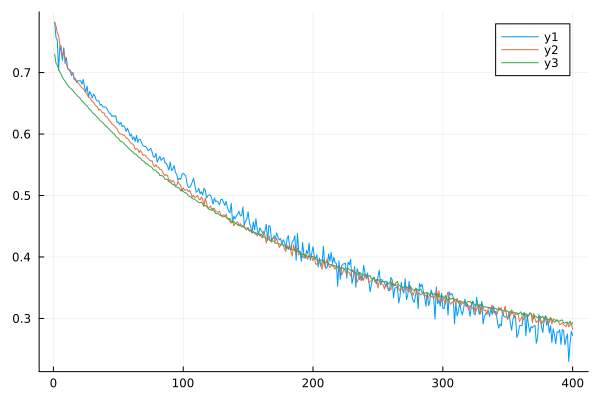

In [28]:
plot(error_dict[1])
plot!(error_dict[2])
plot!(error_dict[3])

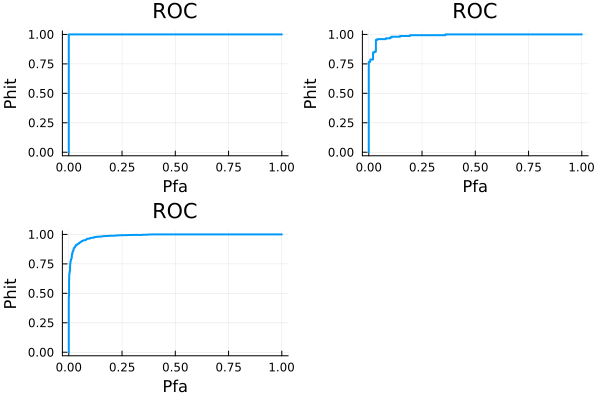

In [29]:
nn=1
plots_tmp = []
for nn in 1:3
    tar = res_dict[nn]["testingTargets"]
    non = res_dict[nn]["testingNonTargets"]
    r = roc(tar, non)
    push!( plots_tmp , plot(r, traditional=true , linewidth = 2) )  
end
plot(plots_tmp...)

In [38]:
[ res_dict[nn]["testing"] for nn in 1:length(res_dict) ]

3-element Vector{Float64}:
 0.8666666666666667
 0.92
 0.901

In [30]:
testing_perc = 0.3
kk = 1
error_dict = Dict()
res_dict = Dict()
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    error_dict[nn] = errors
    res_dict[nn] = res
end

In [31]:
kk = 1
testing_perc = 0.3


benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    bb = @benchmark vanillaSGC($nn,$kk,$trainInds,$testInds)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    println(size(networks_X[nn])[1])
end

100
1000
10000


In [32]:
benchmarkDicts_k

Dict{Any, Any} with 4 entries:
  "allocs" => Any[52561, 53367, 63002]
  "time"   => Any[1.48361e7, 7.78216e7, 2.35669e9]
  "memory" => Any[19262736, 168776960, 4513043792]
  "gctime" => Any[0.0, 2.63392e6, 4.37768e8]

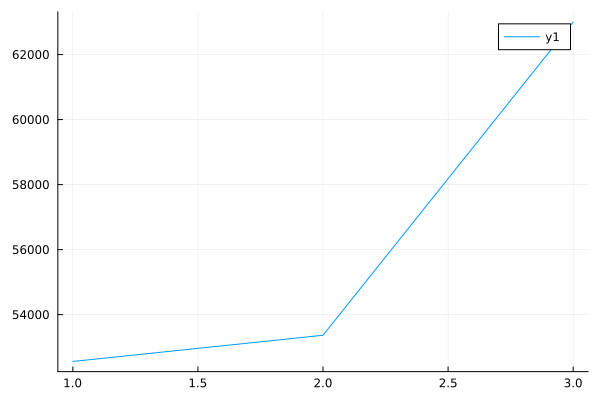

In [33]:
plot(benchmarkDicts_k["allocs"])

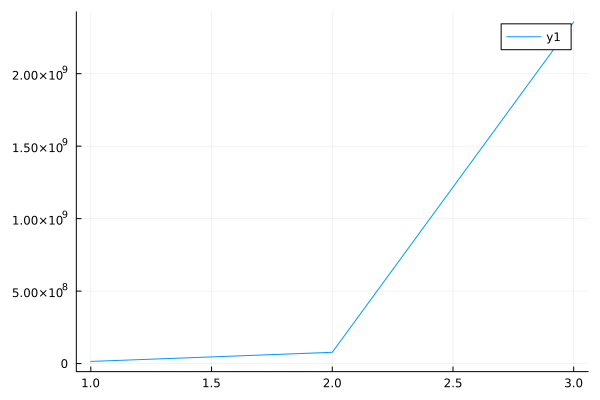

In [34]:
plot(benchmarkDicts_k["time"])

In [59]:
###################################################################3

In [70]:
nn = 3
kk = 0

Xdata = networks_X[nn]'
X_dim = size(Xdata)[1]
display(X_dim)
# (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
Xdata_Conv = ( (A2S(ER_BA_SF_WS_Block_matrices[nn])^kk) * networks_X[nn] )'

#display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = networks_Y_cold[nn]
Y_dim = 3 #size(Ydata)[1]
#println(Ydata[1:10]);println(Ydata[end-10:end]);
println("one hot ?..")
Ydata_1Hot = onehotbatch( Ydata , [1,2,3] )
display(Ydata_1Hot)
#display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
lossSGC(x,y) = Flux.crossentropy( modelSGC(x) , y )

optim = Adam( 0.01 );
pars = Flux.params( modelSGC )
data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) , batchsize=10 , shuffle=true )
for epoch in 1:500
    #Flux.train!( lossSGC , pars , data , optim )
    Flux.train!(pars, data, opt) do x, y
        Flux.crossentropy(modelSGC(x), y)
    end
end

mean( onecold( modelSGC(Xdata_Conv), [1,2,3] ) .== Ydata )

6

one hot ?..


3×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

0.9954

In [20]:
XdataTest = hcat( repeat( [1,0,0,0,1,0] , 1 , 50 ) , repeat( [0,1,0,0,1,0] , 1 , 25 ) , repeat( [0,0,1,0,1,0] , 1 , 25 ) )
display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = append!(repeat( [1] , 50 ) , repeat( [2] , 25 ) , repeat( [3] , 25 ) )
println(Ydata[1:10]);println(Ydata[end-10:end]);
YdataTest = onehotbatch( Ydata , [ 1 , 2 , 3 ] )
display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelTest = Chain( Dense( 6 => 3 ) , softmax )
lossTest(x,y) = Flux.crossentropy(modelTest(x), y)

optimTest = Adam(0.01);
parsTest = Flux.params(modelTest)
dataTest = Flux.DataLoader( (XdataTest, YdataTest) , batchsize=15 , shuffle=true )
for epoch in 1:200
    Flux.train!(lossTest , parsTest , dataTest, optimTest)
end

6×10 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0

6×11 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

3×11 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  1  1  1  1  1  1

In [22]:
println(onecold(modelTest(XdataTest),[1,2,3]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [23]:
println(onecold(YdataTest,[1,2,3]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [24]:
mean( onecold(modelTest(XdataTest),[1,2,3]) .== onecold(YdataTest,[1,2,3]) )

1.0

In [25]:
Flux.crossentropy( [0.3,0.6,0.1] , 2 )

8.034767042171937

In [26]:
Flux.crossentropy( [0.8,0.1,0.1] , Flux.onehotbatch( [2] , [1,2,3] ) )

2.3025850929940432

In [27]:
Flux.crossentropy( [0.8,0.1,0.1] , [0,1,0] )

2.3025850929940432

In [29]:

nn = 1
optim = Adam(0.01);
y_D_num = size(networks_Y[nn])[2] # 3
x_feature_num = size(networks_X[nn])[2] # 6
Ydata = networks_Y[nn]'

Xdata = networks_X[1]' # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
Xdata

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.959582   0.862213   0.982063    …  0.0417828   0.0786938   0.0175552
 0.0211499  0.056595   0.0091251      0.00151731  0.00904995  0.0218312
 0.0192685  0.0811919  0.00881197     0.9567      0.912256    0.960614
 1.0        1.0        1.0            0.0         0.0         0.0
 0.0        0.0        0.0            0.0         0.0         0.0
 0.0        0.0        0.0         …  1.0         1.0         1.0

In [34]:
#this is a basic testing function set which resembles the SGC approach
X = rand(6, 100)
display(X[:,1:10])
truth = []
for col in eachcol(X)
    if( sum(col) < 2.2 )
        append!(truth,1)
    elseif( sum(col) > 3.25)
        append!(truth,3)
    else
        append!(truth,2)
    end
end
display(truth[1:10]')
model = Chain(Dense(6 => 3), softmax)

Y = Flux.onehotbatch( truth , [1,2,3] ) # Flux.onehotbatch( truth , [true, false] )

display(Y[:,1:10])
data = Flux.DataLoader((X, Y), batchsize=15, shuffle=true);

pars = Flux.params(model)
opt = Flux.Adam(0.01)
for epoch in 1:200
    Flux.train!(pars, data, opt) do x, y
        Flux.crossentropy(model(x), y)
    end
end

predictions = model(X)
display( predictions[:,1:10] )
display( mean( onecold( predictions,[1,2,3] ) .== truth ) )
display( mean( onecold( predictions,[1,2,3] ) .== onecold(Y,[1,2,3]) ) )

6×10 Matrix{Float64}:
 0.715999   0.254652  0.486177  0.639516  …  0.0838244  0.741008  0.213033
 0.551237   0.232586  0.805436  0.020911     0.703908   0.478706  0.599643
 0.809851   0.131874  0.894892  0.982884     0.956237   0.427818  0.379515
 0.642838   0.490083  0.989935  0.527355     0.821153   0.179571  0.673733
 0.0791379  0.433722  0.668326  0.954746     0.905022   0.551002  0.353324
 0.138115   0.997851  0.296197  0.83429   …  0.144961   0.416526  0.92633

1×10 adjoint(::Vector{Any}) with eltype Any:
 2  2  3  3  1  2  3  3  2  2

3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1
 ⋅  ⋅  1  1  ⋅  ⋅  1  1  ⋅  ⋅

3×10 Matrix{Float64}:
 0.0486159  0.0887719  0.00296049  …  0.00610607  0.146908  0.0221382
 0.766256   0.770676   0.182464       0.223218    0.618576  0.768172
 0.185128   0.140552   0.814576       0.770676    0.234516  0.20969

0.85

0.85

In [72]:
@benchmark A2S(AA)

BenchmarkTools.Trial: 100 samples with 6 evaluations.
 Range (min … max):   6.906 μs …  14.133 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.935 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.012 μs ± 751.256 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                             ▂█▃▆▂▆█▂  ▅ █                      
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▁▁▁▁▁▇███████████▇█▅▇▄▅▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▄
  6.91 μs         Histogram: frequency by time         12.4 μs <

 Memory estimate: 13.77 KiB, allocs estimate: 22.